In [4]:
import elephant
import neo
import numpy as np
import quantities as pq
#!pip install neo elephant quantities numpy



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 1.8 MB/s eta 0:00:0000:0100:010m
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 638.4/638.4 kB 6.2 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.2/101.2 kB 6.7 MB/s eta 0:00:00
  Created wheel for elephant: filename=elephant-1.1.0-py3-none-any.whl size=538653 sha256=948543741d582245ba1dd1ccc9002023ce37598b812a75ff9a093217cda97d8d
  Stored in directory: /Users/noriori/Library/Caches/pip/wheels/f9/6a/74/771dfef99518337cb39c3c4875adbbde637e8eb1da7991e7ef
Successfully built elephant


In [8]:
# Function to read .dat file
def read_dat_file(filename, dtype=np.int16):
    with open(filename, 'rb') as f:
        data = np.fromfile(f, dtype=dtype)
    return data

In [9]:
# Define parameters
num_channels = 384  # For example, Neuropixels probe with 384 channels
dtype = np.int16   # Typically Neuropixels data is stored as 16-bit integers
input_file = '/Users/noriori/Desktop/mouse_343_2024-06-13T134652Z/LFP.bin'
output_file = '/Users/noriori/Desktop/mouse_343_2024-06-13T134652Z/LFP.dat'

# Read the raw binary data
data = np.fromfile(input_file, dtype=dtype)

# Reshape the data into (num_channels, num_samples)
num_samples = data.size // num_channels
data = data.reshape((num_samples, num_channels)).T

# Optionally, process the data (e.g., filter, re-reference, etc.


# Write the data to a .dat file
data.tofile(output_file)

In [26]:
# Example usage
filename = '/Users/noriori/Desktop/mouse_343_2024-06-13T134652Z/LFP.dat'
data = read_dat_file(filename)

# Define your sampling rate (you need to know this information)
sampling_rate = 2500  # For example, 30 kHz

# Reshape data if it's multi-channel, for single-channel you can skip this
num_channels = 384  # Set the number of channels appropriately
data = data.reshape(-1, num_channels)

# Convert to microvolts (if necessary), depends on your data scale
data = data * 4.69  # Define your scale factor based on data format


In [42]:
# Select the channel you want to analyze
channel_index = 3# Change this to select a different channel
channel_data = data[:, channel_index]

# Create Neo AnalogSignal object for the selected channel
analogsignal = neo.AnalogSignal(
    data[:, channel_index] * pq.uV,  # Adjust based on your data scale
    sampling_rate=sampling_rate * pq.Hz,
    t_start=0 * pq.s
)

# If multi-channel, create multiple AnalogSignal objects
#analogsignals = [neo.AnalogSignal(
 #   data[:, ch] * pq.uV,  # Adjust based on your data scale
  #  sampling_rate=sampling_rate * pq.Hz,
   # t_start=0 * pq.s
#) for ch in range(num_channels)]


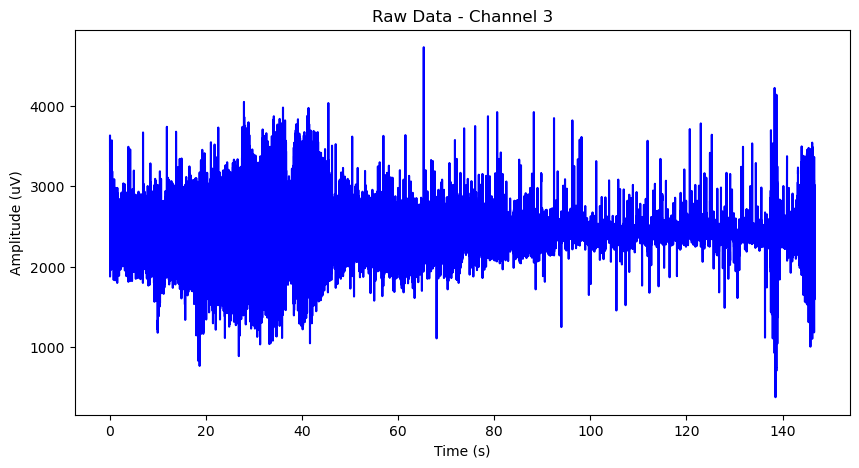

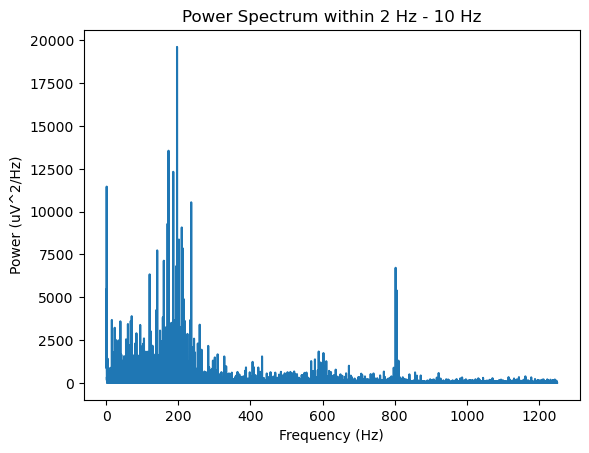

In [56]:
import elephant.spectral
import matplotlib.pyplot as plt

# Perform FFT on single channel
frequencies, power_spectrum = elephant.spectral.welch_psd(analogsignal)

# If multi-channel, apply FFT to each channel and plot
#for idx, signal in enumerate(analogsignals):
    #frequencies, power_spectrum = elephant.spectral.welch_psd(signal)
    
   # frequencies = frequencies.rescale('Hz')
   # power_spectrum = power_spectrum.rescale('uV**2/Hz')

# Create time axis
time = np.arange(len(channel_data)) / sampling_rate

# Define the frequency range of interest
f_min = 2  # Minimum frequency in Hz
f_max = 10  # Maximum frequency in Hz

# Find the indices corresponding to the specified frequency range
start_index = np.argmax(frequencies >= f_min)
end_index = np.argmax(frequencies >= f_max)

# Extract the frequencies and power spectrum within the specified range
frequencies_range = frequencies[start_index:end_index]
power_spectrum_range = power_spectrum[start_index:end_index]

# Convert units for plotting
frequencies_range_rescale = frequencies.rescale('Hz')
power_spectrum_range_rescale = power_spectrum.rescale('uV**2/Hz')

# Flatten the power_spectrum to match the shape of frequencies
power_spectrum_range_squeeze = np.squeeze(power_spectrum_range_rescale)

# Plot the raw data
plt.figure(figsize=(10, 5))
plt.plot(time, channel_data, color='blue')
plt.title('Raw Data - Channel {}'.format(channel_index))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')
plt.show()

# Plot the power spectrum within the specified frequency range
plt.figure()
plt.plot(frequencies_range_rescale, power_spectrum_range_squeeze)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (uV^2/Hz)')
plt.title('Power Spectrum within {} Hz - {} Hz'.format(f_min, f_max))
plt.show()
    